# Understanding the Impacts of China-US Trade War

## Abstract

Since the paper introduces interrupted time series (ITS) analysis as a practical method for event’s impact evaluation, we propose to study if we can apply ITS analysis to a different scenario: the China-United States trade war. To do so, we collect several different types of datasets (e.g., U.S. Trade in Goods with China, US foreign trade with product details) from the United States and China’s official website. We will then use ITS analysis on these datasets and see if there exists a significant impact on China-US trade. Moreover, we may try to extend the ITS analysis method to better interpret multiple events and other factors (e.g. tariffs). The visualization of analysis will allow us to understand the economic outcomes easily. Apart from the general implications for exports and imports, we are also interested in investigating further into other aspects of the trade war: increasing tariffs during the trade war, different levels of impacts in various industries, the resulting change in the trade of their business partners such as the European Union. All these results would provide us with a deeper understanding of the impacts of the trade war, and we would try to interpret them from different perspectives. (Need to be improved)

![tradewar-img](https://knowledge.wharton.upenn.edu/wp-content/uploads/2019/08/U.S.-China-Trade-War-Tariffs.jpg)

In [2]:
# All the packages used
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.subplots import make_subplots
from plotly.graph_objects import layout
import geopandas as gpd
from pycountry_convert import country_name_to_country_alpha3
from plotly.offline import iplot

%matplotlib inline
pd.options.display.max_rows = 10

## Constant and Function Definition

In the following analysis of different questions, there are some constants and functions frequently used in data loading or interrupted times series (ITS) analysis. We will define them here to make the work easier and more clear. Detailed explanation of each function has been covered in its docstring.

In [3]:
# Constant definition
BILATERAL_TRADE_PATH = "./data/trade.csv"
GLOBAL_TRADE_PATH = "./data/oecd_imts_data.csv"

In [4]:
def add_its_features(df, time_col_name, intervention_time):
    """
    For extending the pandas dataframe with features required in interrupted times series (ITS) analysis.
    
    ITS features include:
        - `time_feature` : a continuous variable indicating time from the start of the study up to the end of the period of observation;
        - `intervention` : coded 0 for pre-intervention time points and 1 for post-intervention time points
        - `postslope`    : coded 0 up to the last point before the intervention phase and coded sequentially from 1 thereafter
    
    Parameters
    ----------
    df : pandas Dataframe
        dataframe prepared for ITS analysis
    time_col_name : string
        the column name of time series in the dataframe
    intervention_time : string
        the time of the interrupted event
    Returns
    -------
    df_its : pandas Dataframe
        dataframe df with extended ITS features
    """
    
    df_its = df.copy(deep=True)
    time = list(range(1, len(df_its) + 1))
    df_its["time_feature"] = time
    
    df_its["intervention"] = None
    df_its["intervention"].mask(df_its[time_col_name] <= intervention_time, 0, inplace=True)
    df_its["intervention"].mask(df_its[time_col_name] > intervention_time, 1, inplace=True)
    
    pre = df_its[df_its[time_col_name] <= intervention_time]
    post = df_its[df_its[time_col_name] > intervention_time]
    postslope_pre = [0 for i in range(len(pre))]
    postslope_post = list(range(1, len(post) + 1))
    postslope = postslope_pre + postslope_post
    df_its["postslope"] = postslope
    
    return df_its

In [5]:
def plot_its_result(df, reg_res, time_col_name, target_col_name, intervention_time, title):
    """
    For plotting the ITS regression analysis, specified with the two time periods: pre-intervention and post-intervention.
    
    Parameters
    ----------
    df : pandas Dataframe
        dataframe prepared for ITS analysis
    reg_res : statsmodels RegressionResultsWrapper
        the regression result of its, including the coefficients
    time_col_name : string
        the column name of time series in the dataframe
    target_col_name : string
        the column name of the target variable
    intervention_time : string
        the time of the interrupted event
    """
    # Set the plotting format
    sns.set_style("ticks")
    plt.figure(figsize=(12, 6))

    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = reg_res.params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = df[df[time_col_name] <= intervention_time]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(df), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    g = sns.pointplot(x=df["time_feature"], y=df[target_col_name], 
                        color='black', label=target_col_name+" (By Month)")

    # Set the axis and format
    g.set_title(title, loc="left", fontsize=14, weight="bold")
    g.set_xlabel("Time (Months)")
    g.set_xticks(list(range(0, len(df), 1)))
    g.set_ylabel("Total Amount (millions of U.S. dollars)")
    g.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    plt.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    plt.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    plt.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    plt.text(pre_month_num + 2.5, max(df[target_col_name]), intervention_time, ha="center")

    plt.legend()
    plt.show()
    
    return 

## 1. China-US Bilateral Trade: A History Review

## 2. How does the trade war affect the bilateral trade between China and the US?

The core question in our research is the analysis of trade war's direct impacts on the bilateral trade, including exports and imports amount. First we load the data from the United States Census website [(data source)](https://www.census.gov/foreign-trade/balance/c5700.html):

In [6]:
bilateral_df = pd.read_csv(BILATERAL_TRADE_PATH)
bilateral_df

,time,exports,imports
0,2016-01,8208.9,37126.4
1,2016-02,8080.5,36066.9
2,2016-03,8925.6,29812.3
3,2016-04,8679.7,32920.2
4,2016-05,8542.0,37513.7
...,...,...,...
52,2020-05,9641.7,36598.2
53,2020-06,9242.2,37639.5
54,2020-07,9037.0,40657.3
55,2020-08,11036.1,40816.4


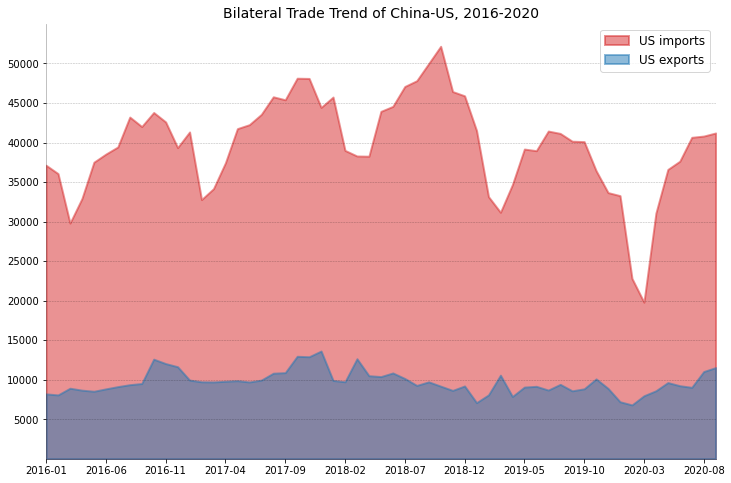

In [7]:
# Plot the trend of the trade
x = bilateral_df['time'].values.tolist()
imports = bilateral_df['imports'].values.tolist()
exports = bilateral_df['exports'].values.tolist()

# Fill the area between exports and imports
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.fill_between(x, y1=imports, y2=0, label="US imports", alpha=0.5, color='tab:red', linewidth=2)
ax.fill_between(x, y1=exports, y2=0, label="US exports", alpha=0.5, color='tab:blue', linewidth=2)

# Figure format setting
ax.set_title('Bilateral Trade Trend of China-US, 2016-2020', fontsize=14)
ax.set(ylim=[0, 55000])
ax.legend(loc='best', fontsize=12)
plt.xticks(x[::5], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(5000, 55000, 5000), fontsize=10)
plt.xlim(x[0], x[-1])

# Draw Tick lines  
for y in np.arange(5000, 55000, 5000):    
    plt.hlines(y, xmin=0, xmax=len(x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

Given the plot above, we observe that:

(1) US imports from China are much higher than its exports. The US trade deficit in bilateral trade is approximately 30 billion dollars per month.

(2) U.S. imports from China fluctuate greatly each month and show a certain degree of cyclical characteristics.

(3) After 2020, monthly trade volume has changed greatly.

### Trade war outbreak analysis: First trial

Firstly, according to the circumstance (3), we infer that COVID-19 pandemic has greatly impacted the bilateral trade. Also, in 2020 Jan 15, U.S. President Donald Trump and China's Vice Premier Liu He signed the US–China Phase One trade deal in Washington DC [(source)](https://www.bloomberg.com/news/articles/2020-01-15/u-s-china-sign-phase-one-of-trade-deal-trump-calls-remarkable). This agreement marked a phased settlement of the trade war.

According to the two factors above, we think that the trade amount in 2020 do not help to investigate the trade war's impacts because it's hard to control the variable. The pandemic may be the cause of sharp decrease in US imports but the agreement could lead to the following increasing tread. Hence, we focus our research on year 2016-2019, which is also the main period of the trade war. Let's forget about the crazy and miserable 2020 in this research!

In [8]:
# Convert the datatype to datetime/numeric
bilateral_df.time    = pd.to_datetime(bilateral_df.time)
bilateral_df.exports = pd.to_numeric(bilateral_df.exports)
bilateral_df.imports = pd.to_numeric(bilateral_df.imports)

In [9]:
bilateral_df = bilateral_df[bilateral_df.time < "2020-01"]

We need to add the ITS feature required for segmented regression analysis. Given that the U.S. took actions to apply tariffs on Chinese goods on March 2018 for the first time, we chose it as the trade war event intervention in our analysis.

In [10]:
# Add ITS features (time_feature, intervention, postslope)
bilateral_its_df = add_its_features(bilateral_df, "time", "2018-03")
bilateral_its_df

,time,exports,imports,time_feature,intervention,postslope
0,2016-01-01,8208.9,37126.4,1,0,0
1,2016-02-01,8080.5,36066.9,2,0,0
2,2016-03-01,8925.6,29812.3,3,0,0
3,2016-04-01,8679.7,32920.2,4,0,0
4,2016-05-01,8542.0,37513.7,5,0,0
...,...,...,...,...,...,...
43,2019-08-01,9415.6,41151.1,44,1,17
44,2019-09-01,8597.3,40165.5,45,1,18
45,2019-10-01,8851.2,40114.9,46,1,19
46,2019-11-01,10103.3,36436.6,47,1,20


With the preprocessed data, we can now use segmented regression analysis to investigate the impacts of trade war on the bilateral trade. In detail, we will firstly look into the exports and imports of United States from China:

In [11]:
# Declare the model for exports segmented regression analysis
model_exports = smf.ols(formula='exports ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(42)
res_exports = model_exports.fit()

# Print the summary output
print(res_exports.summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     11.84
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           8.19e-06
Time:                        16:08:13   Log-Likelihood:                -402.16
No. Observations:                  48   AIC:                             812.3
Df Residuals:                      44   BIC:                             819.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8483.9932 

In [12]:
# Declare the model for exports segmented regression analysis
model_imports = smf.ols(formula='imports ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)
# Fits the model
res_imports = model_imports.fit()
# Print the summary output
print(res_imports.summary())

                            OLS Regression Results                            
Dep. Variable:                imports   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     6.823
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           0.000710
Time:                        16:08:13   Log-Likelihood:                -468.68
No. Observations:                  48   AIC:                             945.4
Df Residuals:                      44   BIC:                             952.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.562e+04 

From the regression results, we can see that the trade war has statistically significant impact on U.S. exports to China, both immediately and in the long term: before the trade war, the exports stably increase with the coefficient of `time_feature` is around 129.18. However, the `intervetion`'s coefficient is -2026.33 and `postslope`'s is -191.62, indicating that the intervention not only immediately reduced the export value, but also showed a downward trend in the next two years.

On the other hand, the result on U.S. imports from China has a certain degree of difference with the exports. We can conclude that the imports from China has both higher increasing trend before the trade war (with coefficient 340.74) and more severe downward trend (with coefficient -844.34) after the trade war. However, it shows that the trade war's outbreak led to an immediate increase (with coefficient 2042.09), whereas not statistically significant (with p-value 0.433).

### Further processing: seasonal pattern in trade

**Does the result reliable and trustworthy?** We now need to do some further investigation to strengthen the analysis!

Remember that we observed obvious seasonal pattern in the imports trend. To analyze the intervention's impacts, we need to remove the seasonality in the time series. `seasonal_decompose` will break down the time series into trend, seasonal and residual components. We plot both the imports and exports trend, seasonality and residual for comparison:

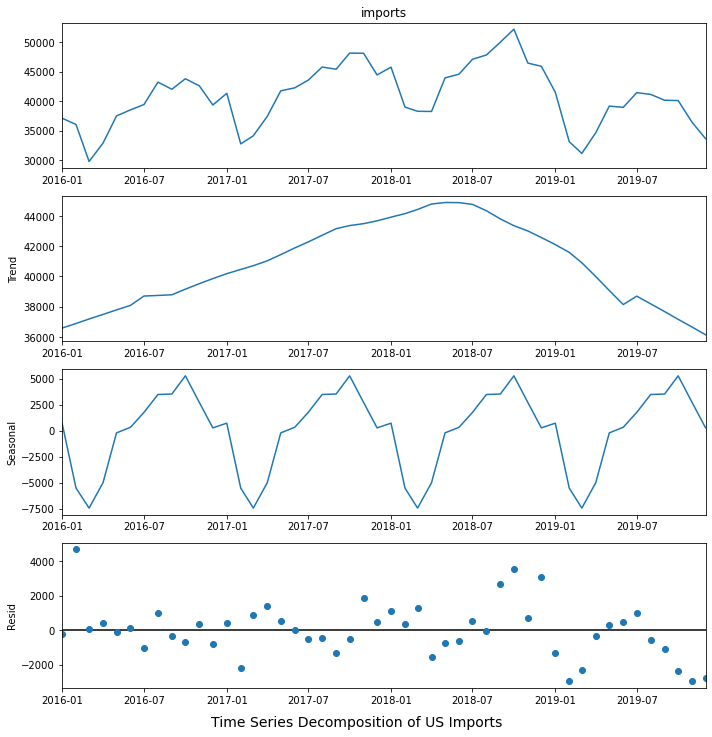

In [13]:
# Decompose 
dates = pd.DatetimeIndex([d for d in bilateral_its_df['time']])
bilateral_its_df.set_index(dates, inplace=True)
result_imports = seasonal_decompose(bilateral_its_df['imports'], model='additive', period=12, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_imports.plot().suptitle('Time Series Decomposition of US Imports', x=0.5, y=0, fontsize=14)
plt.show()

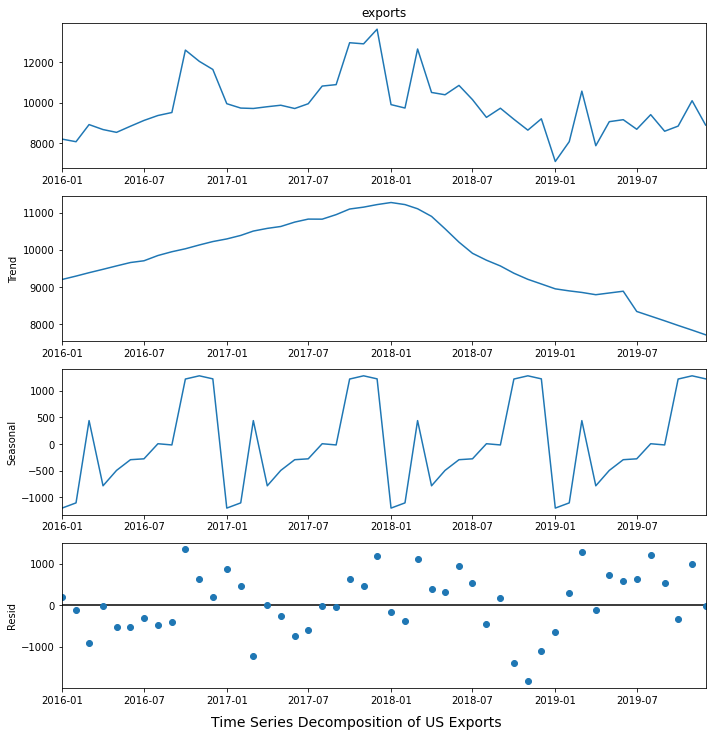

In [14]:
# Decompose 
dates = pd.DatetimeIndex([d for d in bilateral_its_df['time']])
bilateral_its_df.set_index(dates, inplace=True)
result_exports = seasonal_decompose(bilateral_its_df['exports'], model='additive', period=12, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_exports.plot().suptitle('Time Series Decomposition of US Exports', x=0.5, y=0, fontsize=14)
plt.show()

The seasonal pattern in US imports is regular and clear, as we had observed in previous plots. US exports has less significant seasonality than imports. Removing both of them helps the rationality of the regression analysis. Note that the trend in the above plots have revealed the impacts of trade war, but we have to use regression to quantify the impact.

In [15]:
# Add the trend to dataframe
bilateral_its_df["imports_trend"] = result_imports.trend + result_imports.resid
bilateral_its_df["exports_trend"] = result_exports.trend + result_exports.resid

In [16]:
# Declare the model for exports segmented regression analysis
model_imports = smf.ols(formula='imports_trend ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)
# Fits the model
res_imports_bilateral = model_imports.fit()
# Print the summary output
print(res_imports_bilateral.summary())

                            OLS Regression Results                            
Dep. Variable:          imports_trend   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     57.24
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.12e-15
Time:                        16:08:14   Log-Likelihood:                -419.65
No. Observations:                  48   AIC:                             847.3
Df Residuals:                      44   BIC:                             854.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.658e+04 

In [17]:
# Declare the model for exports segmented regression analysis
model_exports = smf.ols(formula='exports_trend ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)
# Fits the model
res_exports_bilateral = model_exports.fit()
# Print the summary output
print(res_exports_bilateral.summary())

                            OLS Regression Results                            
Dep. Variable:          exports_trend   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     23.32
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.45e-09
Time:                        16:08:14   Log-Likelihood:                -386.50
No. Observations:                  48   AIC:                             781.0
Df Residuals:                      44   BIC:                             788.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8879.4937 

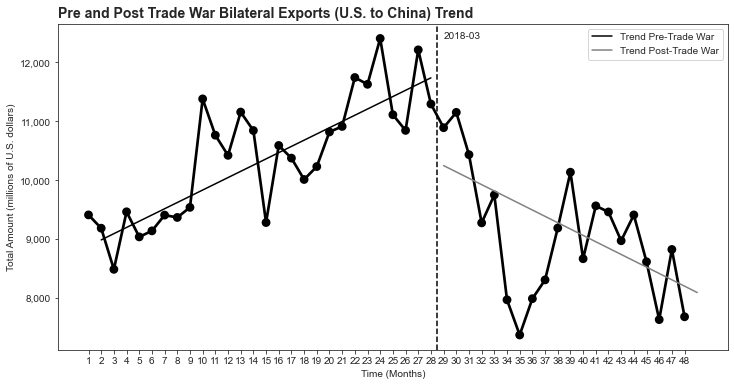

In [18]:
plot_its_result(bilateral_its_df, res_exports_bilateral, "time", "exports_trend", "2018-03", "Pre and Post Trade War Bilateral Exports (U.S. to China) Trend")

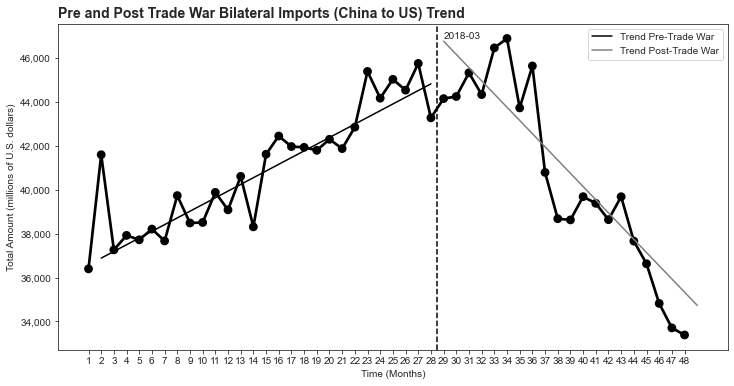

In [19]:
plot_its_result(bilateral_its_df, res_imports_bilateral, "time", "imports_trend", "2018-03", "Pre and Post Trade War Bilateral Imports (China to US) Trend")

After removing the seasonality in the trade data, we can see that all the coefficients are now statistically significant now (p-value < 0.05). Moreover, the R-squared score (i.e., coefficient of determination) of the regression results have increased a lot, indicating that the model fits the data better than not being processed.

### Trade war outbreak analysis with global comparator group

Now that we have removed the seasonality in data, can we make the final conclusion now? Not really. We have not selected a comparator group to strengthen our results. If the intervention's impact is obvious on the treatment group but does not exist in the control group, then we can draw more convincing conclusion.

Since China-US is the most important bilateral trade relationship in the world, any other bilateral trade in the world could be deeply impacted by it, e.g. EU, Japan. We think that using the global trade amount as the comparator group is a resonable choice. It will help us to exclude other global event's impact such as world-wide financial crisis and COVID-19 pandemic.

In this section, we will use the data from Organisation for Economic Co-operation and Development (OECD). [data source](https://stats.oecd.org/Index.aspx?DataSetCode=MEI_TRD#) 

We export the "Monthly International Merchandise Trade" (IMTS) series from 2016-01 to 2020-10. Then, we will load the data and extract the information we need:

In [20]:
# Load original csv data
oecd_df = pd.read_csv(GLOBAL_TRADE_PATH)
oecd_df

,SUBJECT,Subject,LOCATION,Country,Measure,Frequency,TIME,Time,Unit,Value
0,XTIMVA01,Imports in goods (value),BRIICS,"BRIICS economies - Brazil, Russia, India, Indo...","US-Dollar converted, Seasonally adjusted",Monthly,Jan-16,Jan-16,US Dollar,193.5231
1,XTIMVA01,Imports in goods (value),BRIICS,"BRIICS economies - Brazil, Russia, India, Indo...","US-Dollar converted, Seasonally adjusted",Monthly,Feb-16,Feb-16,US Dollar,185.7310
2,XTIMVA01,Imports in goods (value),BRIICS,"BRIICS economies - Brazil, Russia, India, Indo...","US-Dollar converted, Seasonally adjusted",Monthly,Mar-16,Mar-16,US Dollar,195.5028
3,XTIMVA01,Imports in goods (value),BRIICS,"BRIICS economies - Brazil, Russia, India, Indo...","US-Dollar converted, Seasonally adjusted",Monthly,Apr-16,Apr-16,US Dollar,199.8743
4,XTIMVA01,Imports in goods (value),BRIICS,"BRIICS economies - Brazil, Russia, India, Indo...","US-Dollar converted, Seasonally adjusted",Monthly,May-16,May-16,US Dollar,203.9385
...,...,...,...,...,...,...,...,...,...,...
45848,XTNTVA01,Net trade in goods (value),EU27_2020,European Union – 27 countries (from 01/02/2020),National Currency,Monthly,May-20,May-20,National currency,12.3736
45849,XTNTVA01,Net trade in goods (value),EU27_2020,European Union – 27 countries (from 01/02/2020),National Currency,Monthly,Jun-20,Jun-20,National currency,26.7821
45850,XTNTVA01,Net trade in goods (value),EU27_2020,European Union – 27 countries (from 01/02/2020),National Currency,Monthly,Jul-20,Jul-20,National currency,33.2987
45851,XTNTVA01,Net trade in goods (value),EU27_2020,European Union – 27 countries (from 01/02/2020),National Currency,Monthly,Aug-20,Aug-20,National currency,13.8396


In [21]:
# Select OECD-Total and Non-OECD countries
country_queries = ["OECD - Total", "Argentina", "Brazil", "China (People's Republic of)", "Costa Rica", "India", 
                   "Indonesia", "Russia", "South Arabia", "South Africa"]
subject_choices = ["Imports in goods (value)", "Exports in goods (value)"]
measure = ["US-Dollar converted, Seasonally adjusted"]

target_df = oecd_df[oecd_df["Country"].isin(country_queries) & oecd_df["Subject"].isin(subject_choices) & oecd_df["Measure"].isin(measure)]
target_df

,SUBJECT,Subject,LOCATION,Country,Measure,Frequency,TIME,Time,Unit,Value
172,XTIMVA01,Imports in goods (value),OECD,OECD - Total,"US-Dollar converted, Seasonally adjusted",Monthly,Jan-16,Jan-16,US Dollar,794.772000
173,XTIMVA01,Imports in goods (value),OECD,OECD - Total,"US-Dollar converted, Seasonally adjusted",Monthly,Feb-16,Feb-16,US Dollar,815.228800
174,XTIMVA01,Imports in goods (value),OECD,OECD - Total,"US-Dollar converted, Seasonally adjusted",Monthly,Mar-16,Mar-16,US Dollar,799.548600
175,XTIMVA01,Imports in goods (value),OECD,OECD - Total,"US-Dollar converted, Seasonally adjusted",Monthly,Apr-16,Apr-16,US Dollar,823.254000
176,XTIMVA01,Imports in goods (value),OECD,OECD - Total,"US-Dollar converted, Seasonally adjusted",Monthly,May-16,May-16,US Dollar,818.007900
...,...,...,...,...,...,...,...,...,...,...
36032,XTIMVA01,Imports in goods (value),ARG,Argentina,"US-Dollar converted, Seasonally adjusted",Monthly,Jun-20,Jun-20,US Dollar,3.143421
36033,XTIMVA01,Imports in goods (value),ARG,Argentina,"US-Dollar converted, Seasonally adjusted",Monthly,Jul-20,Jul-20,US Dollar,3.116132
36034,XTIMVA01,Imports in goods (value),ARG,Argentina,"US-Dollar converted, Seasonally adjusted",Monthly,Aug-20,Aug-20,US Dollar,3.317366
36035,XTIMVA01,Imports in goods (value),ARG,Argentina,"US-Dollar converted, Seasonally adjusted",Monthly,Sep-20,Sep-20,US Dollar,3.781135


In [22]:
# Calculate the monthly amount of global trend
global_monthly_df = target_df.groupby(["Subject", "Time"]).aggregate({'Value':'sum'})
global_monthly_df = global_monthly_df.unstack(level=0)["Value"]

global_monthly_df.index = pd.to_datetime(global_monthly_df.index.map(lambda x : datetime.datetime.strptime(x, '%b-%y')))
global_monthly_df = global_monthly_df.sort_values(by='Time')
global_monthly_df = global_monthly_df[global_monthly_df.index < "2020-01"]
global_monthly_df

Subject,Exports in goods (value),Imports in goods (value)
Time,,
2016-01-01,1001.650834,994.432342
2016-02-01,1032.918124,1007.403375
2016-03-01,1018.432451,1000.905051
2016-04-01,1049.745802,1028.867419
2016-05-01,1039.592511,1027.884420
...,...,...
2019-08-01,1220.061182,1239.710629
2019-09-01,1212.448275,1221.944116
2019-10-01,1218.068777,1220.068891


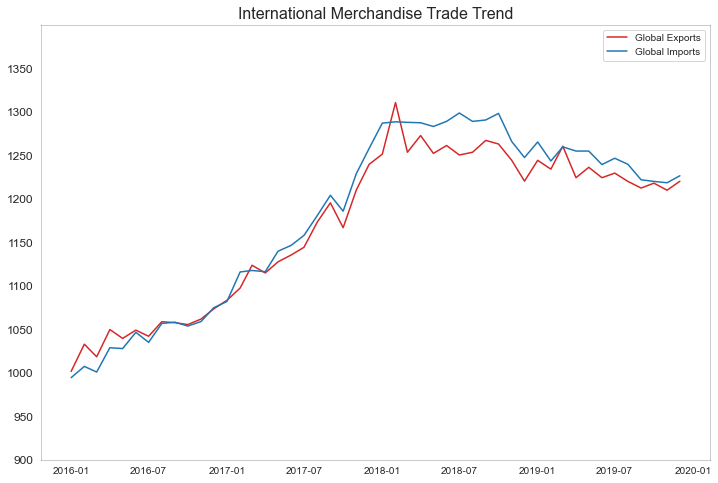

In [23]:
# Plot the time series (global trade trend)
fig, ax = plt.subplots(1,1,figsize=(12, 8))
y_LL = 900
y_UL = 1400
y_interval = 50

plt.plot(global_monthly_df.index.values, global_monthly_df["Exports in goods (value)"].values, lw=1.5, color='tab:red', label="Global Exports")
plt.plot(global_monthly_df.index.values, global_monthly_df["Imports in goods (value)"].values, lw=1.5, color='tab:blue', label="Global Imports")

# Decorations    
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)        

# Lighten borders
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.title('International Merchandise Trade Trend', fontsize=16)
plt.yticks(range(y_LL, y_UL, y_interval), [str(y) for y in range(y_LL, y_UL, y_interval)], fontsize=12)    
plt.ylim(y_LL, y_UL)
plt.legend()
plt.show()

Interestingly, we observe that the increasing trend of International Merchandise Trade amount also slowed down and gradually decreased after 2018. We will apply segmented regression analysis to see the trend's relationship with the trade war:

In [24]:
global_monthly_df["time"] = global_monthly_df.index.values

# Add ITS features (time_feature, intervention, postslope)
global_its_df = add_its_features(global_monthly_df, "time", "2018-03")
global_its_df = global_its_df.rename(columns={'Exports in goods (value)': 'exports', 'Imports in goods (value)': 'imports'}, errors="raise")
global_its_df

Subject,exports,imports,time,time_feature,intervention,postslope
Time,,,,,,
2016-01-01,1001.650834,994.432342,2016-01-01,1,0,0
2016-02-01,1032.918124,1007.403375,2016-02-01,2,0,0
2016-03-01,1018.432451,1000.905051,2016-03-01,3,0,0
2016-04-01,1049.745802,1028.867419,2016-04-01,4,0,0
2016-05-01,1039.592511,1027.884420,2016-05-01,5,0,0
...,...,...,...,...,...,...
2019-08-01,1220.061182,1239.710629,2019-08-01,44,1,17
2019-09-01,1212.448275,1221.944116,2019-09-01,45,1,18
2019-10-01,1218.068777,1220.068891,2019-10-01,46,1,19


In [25]:
# Declare the model for exports segmented regression analysis
model_exports = smf.ols(formula='exports ~ time_feature + C(intervention) + postslope', data=global_its_df)
# Fits the model
res_exports_global = model_exports.fit()
# Print the summary output
print(res_exports_global.summary())

# Declare the model for exports segmented regression analysis
model_imports = smf.ols(formula='imports ~ time_feature + C(intervention) + postslope', data=global_its_df)
# Fits the model
res_imports_global = model_imports.fit()
# Print the summary output
print(res_imports_global.summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     292.2
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.65e-29
Time:                        16:08:15   Log-Likelihood:                -209.38
No. Observations:                  48   AIC:                             426.8
Df Residuals:                      44   BIC:                             434.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              977.3248 

Clearly, the global trade did not immediately experience the negative effects of the trade war, for the intervention's coefficients are positive (21.12 and 34.23 respectively). However, the long-term negative effect exists in the regression results (with negative postslope's coefficients).

Does this overturn our previous conclusion in China-US Trade Trend? 

Not exactly, because the long-term effect is less noticeable than the impact discovered China-US trade relationships:

In [26]:
# Compare the relative long-term impact
print("[Imports China-US] The ratio of postslope post trade war to slope pre trade war is %.2f."% abs(-905.9217/304.9529))
print("[Imports Global] The ratio of postslope post trade war to slope pre trade war is %.2f."% abs(-15.3932/11.4242))
print("")
print("[Exports US-China] The ratio of postslope post trade war to slope pre trade war is %.2f."% abs(-213.6439/105.8624))
print("[Exports Global] The ratio of postslope post trade war to slope pre trade war is %.2f."% abs(-12.6810/10.0023))

[Imports China-US] The ratio of postslope post trade war to slope pre trade war is 2.97.
[Imports Global] The ratio of postslope post trade war to slope pre trade war is 1.35.

[Exports US-China] The ratio of postslope post trade war to slope pre trade war is 2.02.
[Exports Global] The ratio of postslope post trade war to slope pre trade war is 1.27.


The plot below can better reflect the difference in both the immediate/long-term impact on China-US bilateral trade and the international market:

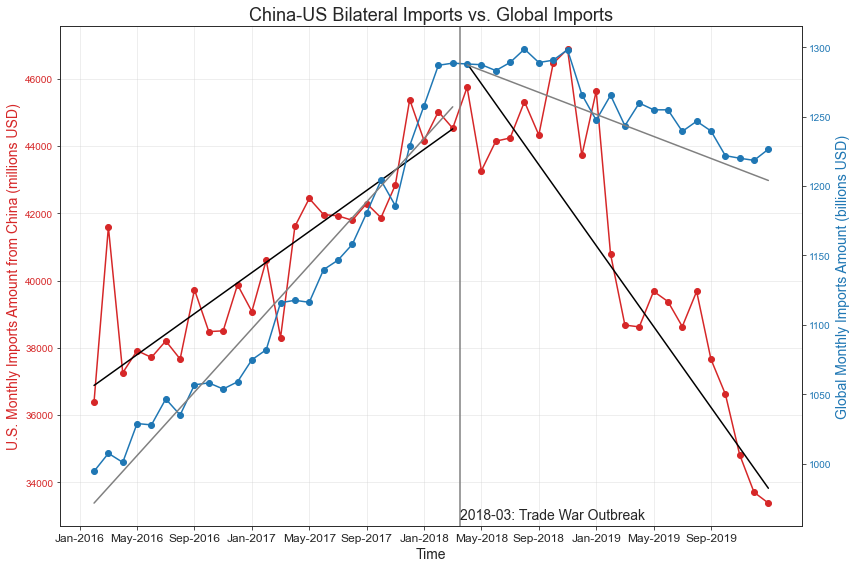

In [27]:
# [Imports] Plot the compared two time series (China-US vs. Global) with different scales

x = bilateral_its_df["time_feature"]
y1 = bilateral_its_df["imports_trend"]
y2 = global_its_df["imports"]

# Plot China-US bilateral line
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax1.scatter(x, y1, color='tab:red')
ax1.plot(x, y1, color='tab:red')

# Plot Global Market line
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(x, y2, color='tab:blue')
ax2.plot(x, y2, color='tab:blue')

# Plot the regression lines
pre_month_num = 26
X_plot_pre = np.linspace(1, pre_month_num, 100)
X_plot_post = np.linspace(pre_month_num+1, len(x), 100)

beta_0, beta_2, beta_1, beta_3 = res_imports_bilateral.params
Y_plot_pre = beta_0 + beta_1 * X_plot_pre
Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)
ax1.plot(X_plot_pre, Y_plot_pre, color="black", label="Bilateral Trend Pre-Trade War")
ax1.plot(X_plot_post, Y_plot_post, color="black", label="Bilateral Trend Post-Trade War")

beta_0, beta_2, beta_1, beta_3 = res_imports_global.params
Y_plot_pre = beta_0 + beta_1 * X_plot_pre
Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)
ax2.plot(X_plot_pre, Y_plot_pre, color="gray", label="Global Trend Pre-Trade War")
ax2.plot(X_plot_post, Y_plot_post, color="gray", label="Global Trend Post-Trade War")

# Plot the intervention line (2018-03) TODO: more elegant intervention line?
plt.axvline(pre_month_num+0.5, color="gray", linestyle="-")
plt.text(pre_month_num+0.5, 960, "2018-03: Trade War Outbreak", ha="left", fontsize=14)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=14)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('U.S. Monthly Imports Amount from China (millions USD)', color='tab:red', fontsize=14)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
xticklabels = [i.strftime("%b-%Y") for i in bilateral_its_df["time"]]
ax2.set_ylabel("Global Monthly Imports Amount (billions USD)", color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 4))
ax2.set_xticklabels(xticklabels[::4], rotation=90, fontdict={'fontsize':10})
ax2.set_title("China-US Bilateral Imports vs. Global Imports", fontsize=18)
fig.tight_layout()
plt.show()

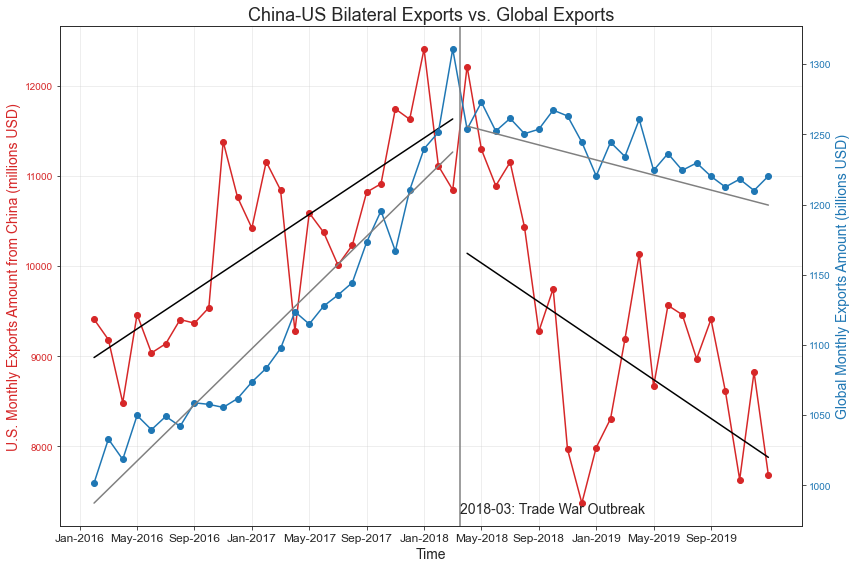

In [28]:
# [Exports] Plot the compared two time series (China-US vs. Global) with different scales

x = bilateral_its_df["time_feature"]
y1 = bilateral_its_df["exports_trend"]
y2 = global_its_df["exports"]

# Plot China-US bilateral line
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax1.scatter(x, y1, color='tab:red')
ax1.plot(x, y1, color='tab:red')

# Plot Global Market line
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(x, y2, color='tab:blue')
ax2.plot(x, y2, color='tab:blue')

# Plot the regression lines
pre_month_num = 26
X_plot_pre = np.linspace(1, pre_month_num, 100)
X_plot_post = np.linspace(pre_month_num+1, len(x), 100)

beta_0, beta_2, beta_1, beta_3 = res_exports_bilateral.params
Y_plot_pre = beta_0 + beta_1 * X_plot_pre
Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)
ax1.plot(X_plot_pre, Y_plot_pre, color="black", label="Bilateral Trend Pre-Trade War")
ax1.plot(X_plot_post, Y_plot_post, color="black", label="Bilateral Trend Post-Trade War")

beta_0, beta_2, beta_1, beta_3 = res_exports_global.params
Y_plot_pre = beta_0 + beta_1 * X_plot_pre
Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)
ax2.plot(X_plot_pre, Y_plot_pre, color="gray", label="Global Trend Pre-Trade War")
ax2.plot(X_plot_post, Y_plot_post, color="gray", label="Global Trend Post-Trade War")

# Plot the intervention line (2018-03) TODO: more elegant intervention line?
plt.axvline(pre_month_num+0.5, color="gray", linestyle="-")
plt.text(pre_month_num+0.5, 980, "2018-03: Trade War Outbreak", ha="left", fontsize=14)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=14)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('U.S. Monthly Exports Amount from China (millions USD)', color='tab:red', fontsize=14)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
xticklabels = [i.strftime("%b-%Y") for i in bilateral_its_df["time"]]
ax2.set_ylabel("Global Monthly Exports Amount (billions USD)", color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 4))
ax2.set_xticklabels(xticklabels[::4], rotation=90, fontdict={'fontsize':10})
ax2.set_title("China-US Bilateral Exports vs. Global Exports", fontsize=18)
fig.tight_layout()
plt.show()

### Conclusion

TODO 大概就是说全球经济不景气 但是中美贸易战对双边贸易的影响要远大于全球经济下行的影响 其中因果关系难以分析 (中美贸易战导致全球经济下行还是说贸易保护主义的兴起导致了贸易战+经济下行？因果关系的分析是时序分析的数据做不到的 算是局限性) 中国出口到美国的产品受的即时影响有一个时间延迟 (intervention不减反增 但是过了几个月后骤减) 但是长期的影响要更显著 (大概是三倍的postslope vs. 两倍postslope)

虽然美国在中美双边贸易中是很大的逆差 但单就进出口而言 中国在贸易战中更加吃亏 (出口到美国的商品减少了 损失更大)

## 3. Does the increasing tariff have direct impacts on the trade？

## 4. What’s the change in the trade amount of China and the US with their primary business partners?

### Look into US trade

In [29]:
# Read US import/export data
US_IE_PATH = "data/us_ie_partner.xlsx"
us_ie = pd.read_excel(US_IE_PATH)
us_ie.head()

,year,CTY_CODE,CTYNAME,IJAN,IFEB,IMAR,IAPR,IMAY,IJUN,IJUL,...,EAPR,EMAY,EJUN,EJUL,EAUG,ESEP,EOCT,ENOV,EDEC,EYR
0,1992,1010,Greenland,0.5,0.0,0.0,0.1,0.0,0.8,1.7,...,0.5,0.5,0.2,0.3,0.2,0.1,0.6,0.2,0.1,3.4
1,1993,1010,Greenland,1.3,0.5,0.8,0.4,0.3,1.2,1.7,...,0.3,0.3,0.3,0.2,0.1,0.1,0.3,0.1,0.3,2.7
2,1994,1010,Greenland,1.6,0.2,2.0,1.1,0.5,0.8,0.6,...,0.3,0.3,0.5,0.1,0.4,0.2,0.4,0.3,0.2,3.2
3,1995,1010,Greenland,1.1,0.4,0.0,0.0,0.3,0.8,0.2,...,0.4,0.3,0.3,0.3,0.1,0.1,0.2,0.1,0.0,2.4
4,1996,1010,Greenland,0.8,0.4,0.4,0.5,0.2,0.5,1.2,...,0.2,0.8,0.4,0.3,0.8,0.1,0.2,0.7,0.3,4.1


In [30]:
# Split two dataframe: import and export
us_import = us_ie.iloc[:, :16]
us_export = pd.concat([us_ie.iloc[:, :3], us_ie.iloc[:, 16:29]], axis=1)

us_import.head()
us_export.head()

,year,CTY_CODE,CTYNAME,EJAN,EFEB,EMAR,EAPR,EMAY,EJUN,EJUL,EAUG,ESEP,EOCT,ENOV,EDEC,EYR
0,1992,1010,Greenland,0.2,0.2,0.3,0.5,0.5,0.2,0.3,0.2,0.1,0.6,0.2,0.1,3.4
1,1993,1010,Greenland,0.1,0.2,0.4,0.3,0.3,0.3,0.2,0.1,0.1,0.3,0.1,0.3,2.7
2,1994,1010,Greenland,0.1,0.1,0.3,0.3,0.3,0.5,0.1,0.4,0.2,0.4,0.3,0.2,3.2
3,1995,1010,Greenland,0.1,0.2,0.3,0.4,0.3,0.3,0.3,0.1,0.1,0.2,0.1,0.0,2.4
4,1996,1010,Greenland,0.0,0.1,0.2,0.2,0.8,0.4,0.3,0.8,0.1,0.2,0.7,0.3,4.1


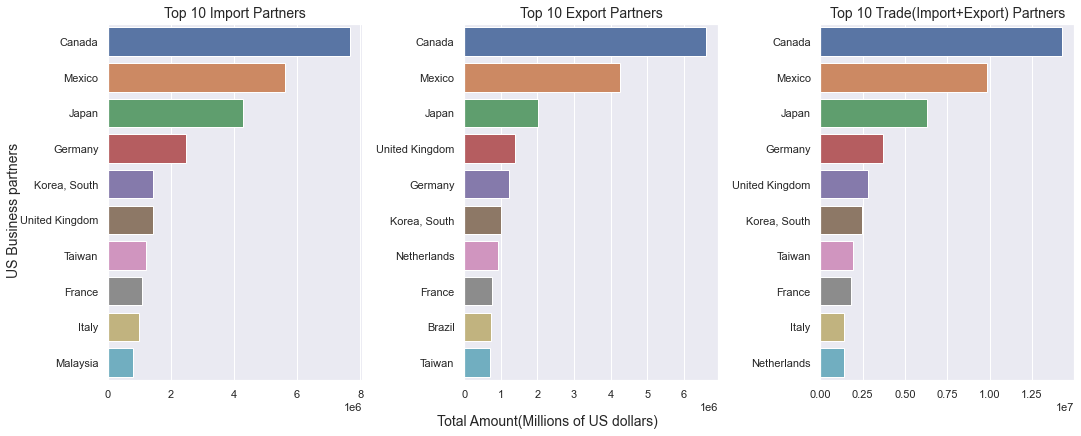

In [31]:
# To find US top trade partners, we aggregate the total trade amount each year
# Find top five import partners (without China)
us_import_year = us_import.filter(['CTYNAME','IYR'], axis=1)
us_import_year = us_import_year.groupby('CTYNAME').sum()
us_import_year = us_import_year.drop('China')
us_import_year = us_import_year.sort_values(by=['IYR'], ascending=False)

# Find top five export partners (without China)
us_export_year = us_export.filter(['CTYNAME','EYR'], axis=1)
us_export_year = us_export_year.groupby('CTYNAME').sum()
us_export_year = us_export_year.drop('China')
us_export_year = us_export_year.sort_values(by=['EYR'], ascending=False)

# Find top trade partners (without China)
us_ie_year = pd.concat([us_import_year, us_export_year], axis=1)
us_ie_year['SUM'] = us_ie_year.IYR + us_ie_year.EYR
us_ie_year = us_ie_year.sort_values(by=['SUM'], ascending=False)

# Visualize to get a clear picture on US top ten trade partners
us_import_year_top = us_import_year[:10]
us_export_year_top = us_export_year[:10]
us_ie_year_top = us_ie_year[:10]
sns.set(rc={'figure.figsize':(15,6)})

fig = plt.figure()
ax1 = plt.subplot(131)
sns.barplot(us_import_year_top.IYR,us_import_year_top.index).set_title('Top 10 Import Partners', fontsize=14)
ax2 = plt.subplot(132)
sns.barplot(us_export_year_top.EYR,us_export_year_top.index).set_title('Top 10 Export Partners', fontsize=14)
ax3 = plt.subplot(133)
sns.barplot(us_ie_year_top.SUM,us_ie_year_top.index).set_title('Top 10 Trade(Import+Export) Partners', fontsize=14)

ax1.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax3.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)
ax3.yaxis.label.set_visible(False)

fig.text(0.5, 0, 'Total Amount(Millions of US dollars)', ha='center', fontsize=14)
fig.text(0, 0.5, 'US Business partners', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.show()

From the above plots, we can easily know the US primary trade partners. We then decide to look into top10 import partners and top10 export partners respectively.

In [32]:
# Create dataframe for each top 10 import partners
# We focus data since 2016
us_import = us_import.loc[us_import['year'] >= 2016]
us_export = us_export.loc[us_export['year'] >= 2016]

def create_us_ie_top10(CTYNAME, df, ie):
    top10 = pd.DataFrame(columns = ['time', ie])
    tmp = df.loc[df['CTYNAME'] == CTYNAME]
    for i, tuples in enumerate(tmp.itertuples(), 0):
        for j in range(1,13):
            top10.loc[(12*i) + j-1] = [str(2016+i) +'-'+str(j), tuples[j+3]]
    return top10

us_import_top10 = us_import_year_top.index
us_import_df = []
us_export_top10 = us_export_year_top.index
us_export_df = []

for i in range(10):
    us_import_df.append(create_us_ie_top10(us_import_top10[i], us_import, 'imports'))
    us_export_df.append(create_us_ie_top10(us_export_top10[i], us_export, 'exports'))

us_import_df[0].head()
us_export_df[0].head()

,time,exports
0,2016-1,19700.273865
1,2016-2,20904.437760
2,2016-3,23252.724610
3,2016-4,23349.632992
4,2016-5,23075.089765


In [33]:
# Analysis on import partners
us_imports_model = []
us_imports_its = []

for partners in us_import_df:
    # Convert the datatype to datetime/numeric
    partners.time    = pd.to_datetime(partners.time)
    partners.imports = pd.to_numeric(partners.imports)

    # Remove time >=2020-01
    partners = partners.loc[partners['time'] < '2020-01']

    # Add ITS features (time_feature, intervention, postslope)
    its_import = add_its_features(partners, "time", "2018-03")

    # Declare the model for exports segmented regression analysis
    model_imports = smf.ols(formula='imports ~ time_feature + C(intervention) + postslope', data=its_import)

    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(42)
    res_imports = model_imports.fit()
    us_imports_model.append(res_imports)
    us_imports_its.append(its_import)

# Print the summary output
print(us_imports_model[0].summary())

                            OLS Regression Results                            
Dep. Variable:                imports   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     19.09
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.45e-08
Time:                        16:08:20   Log-Likelihood:                -411.92
No. Observations:                  48   AIC:                             831.8
Df Residuals:                      44   BIC:                             839.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              2.23e+04 

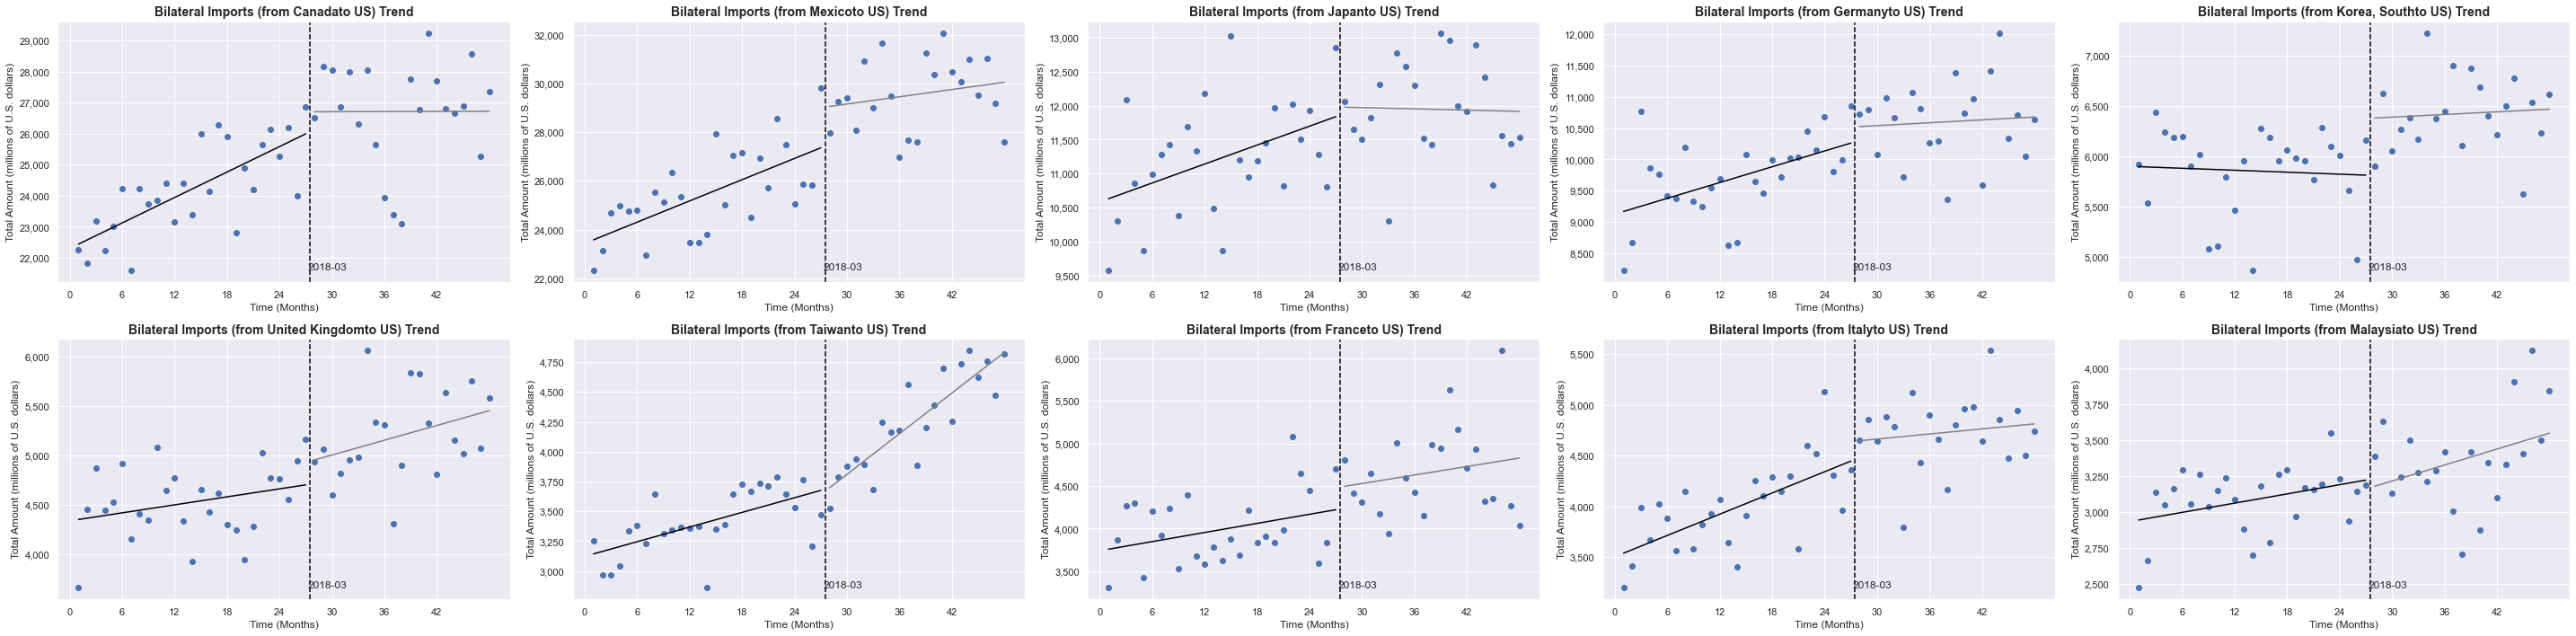

In [34]:
# Plot ITS to see the result on import partners
fig, axs = plt.subplots(2, 5, figsize=(40,10))

for i, ax in enumerate(fig.axes):
    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = us_imports_model[i].params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = us_imports_its[i][us_imports_its[i]["time"] <= "2018-03"]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(us_imports_its[i]), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    ax.scatter(x=us_imports_its[i]["time_feature"], y=us_imports_its[i]["imports"])
    # Set the axis and format
    ax.set_title("Bilateral Imports (from "+ us_import_top10[i]+ "to US) Trend", loc="center", fontsize=14, weight="bold")
    ax.set_xlabel("Time (Months)")
    ax.set_xticks(list(range(0, len(us_imports_its[i]), 6)))
    ax.set_ylabel("Total Amount (millions of U.S. dollars)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    ax.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    ax.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    ax.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    ax.text(pre_month_num + 2.5, min(us_imports_its[i]["imports"]), "2018-03", ha="center")

plt.tight_layout()
plt.show()

In [35]:
# Analysis on export partners
us_exports_model = []
us_exports_its = []

for partners in us_export_df:
    # Convert the datatype to datetime/numeric
    partners.time    = pd.to_datetime(partners.time)
    partners.exports = pd.to_numeric(partners.exports)

    # Remove time >=2020-01
    partners = partners.loc[partners['time'] < '2020-01']

    # Add ITS features (time_feature, intervention, postslope)
    its_export = add_its_features(partners, "time", "2018-03")

    # Declare the model for exports segmented regression analysis
    model_exports = smf.ols(formula='exports ~ time_feature + C(intervention) + postslope', data=its_export)

    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(42)
    res_exports = model_exports.fit()
    us_exports_model.append(res_exports)
    us_exports_its.append(its_export)

# Print the summary output
print(us_exports_model[0].summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     10.04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.67e-05
Time:                        16:08:22   Log-Likelihood:                -414.39
No. Observations:                  48   AIC:                             836.8
Df Residuals:                      44   BIC:                             844.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.142e+04 

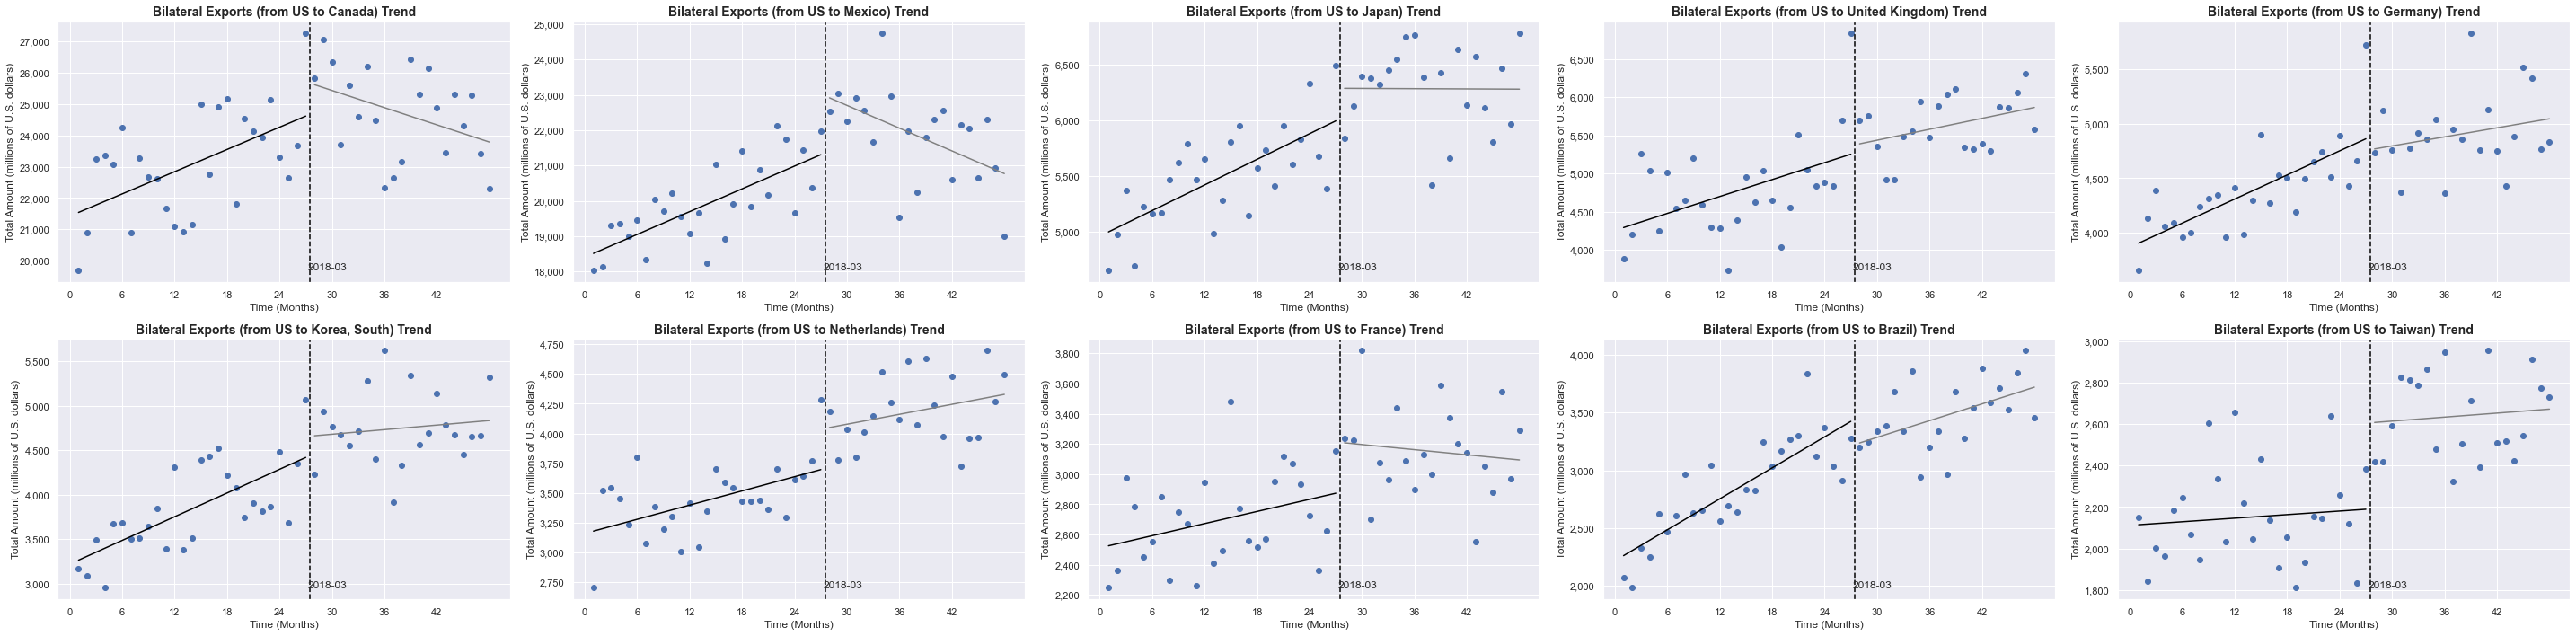

In [36]:
# Plot ITS to see the result on export partners
fig, axs = plt.subplots(2, 5, figsize=(40,10))

for i, ax in enumerate(fig.axes):
    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = us_exports_model[i].params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = us_exports_its[i][us_exports_its[i]["time"] <= "2018-03"]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(us_exports_its[i]), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    ax.scatter(x=us_exports_its[i]["time_feature"], y=us_exports_its[i]["exports"])
    # Set the axis and format
    ax.set_title("Bilateral Exports (from US to "+ us_export_top10[i]+ ") Trend", loc="center", fontsize=14, weight="bold")
    ax.set_xlabel("Time (Months)")
    ax.set_xticks(list(range(0, len(us_exports_its[i]), 6)))
    ax.set_ylabel("Total Amount (millions of U.S. dollars)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    ax.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    ax.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    ax.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    ax.text(pre_month_num + 2.5, min(us_exports_its[i]["exports"]), "2018-03", ha="center")

plt.tight_layout()
plt.show()

For most of the US business partners, the impact of trade war can hardly be seen from ITS plot. Thus, we proposed a new formula to get a more clear idea of the impact on different business partners.

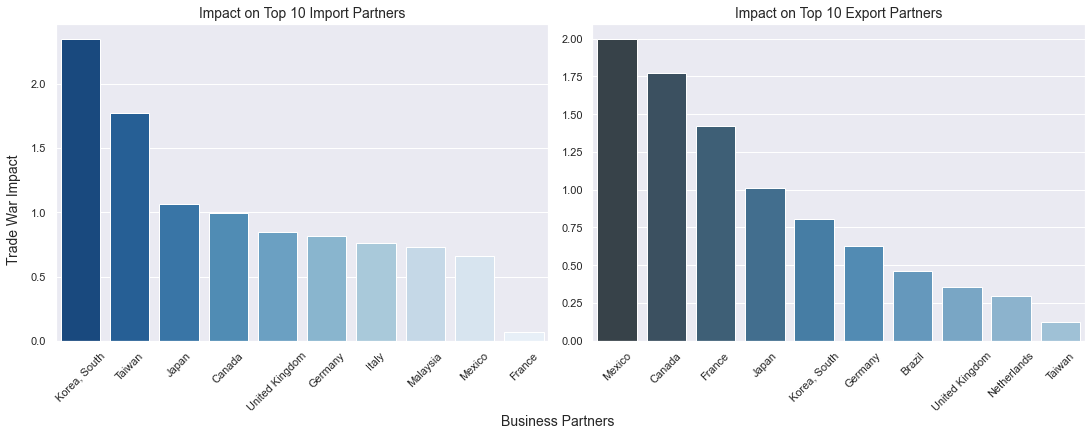

In [37]:
# More analysis on top10 import/export partners
# We use data from ITS reports and propose a new formula: abs(postslope.coeff/time feature.coeff)
import_impact = []
export_impact = []

for i in range(10):
    import_impact.append(np.abs(us_imports_model[i].params[3]/us_imports_model[i].params[2]))
    export_impact.append(np.abs(us_exports_model[i].params[3]/us_exports_model[i].params[2]))

# Visualize
data_import = {'CTYNAME': us_import_top10, 'imports': import_impact}
data_export = {'CTYNAME': us_export_top10, 'exports': export_impact}
us_import_impact = pd.DataFrame(data=data_import)
us_export_impact = pd.DataFrame(data=data_export)

us_import_impact = us_import_impact.sort_values(by=['imports'], ascending=False)
us_export_impact = us_export_impact.sort_values(by=['exports'], ascending=False)

sns.set(rc={'figure.figsize':(15,6)})
fig = plt.figure()
ax1 = plt.subplot(121)
sns.barplot(x=us_import_impact.CTYNAME, y=us_import_impact.imports, data=us_import_impact, capsize=.05, palette="Blues_r").set_title('Impact on Top 10 Import Partners', fontsize=14)
ax2 = plt.subplot(122)
sns.barplot(x=us_export_impact.CTYNAME, y=us_export_impact.exports, data=us_export_impact, capsize=.05, palette="Blues_d").set_title('Impact on Top 10 Export Partners', fontsize=14)

ax1.set_xticklabels(us_import_impact.CTYNAME, rotation=45)
ax2.set_xticklabels(us_export_impact.CTYNAME, rotation=45)

ax1.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

fig.text(0.5, 0, 'Business Partners', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Trade War Impact', va='center', rotation='vertical', fontsize=14)

#ax1.axvline(pre_month_num + 0.5, color="black", linestyle="--")
#ax2.axvline(pre_month_num + 0.5, color="black", linestyle="--")

fig.tight_layout()
plt.show()

From the above plot, we can easily view the trade war impact on different business partners. The trade war has more impact on US import partners: South Korea and Taiwan, with little impact on France. On the other hand, as being the US export partners, Mexico, Canada and France gain more influence from the trade war.

### Look into China trade

In [38]:
# Read China import/export data
CHINA_IE_PATH = 'data/china_ie_partner/'
yr = ['2016','2017','2018','2019']
month = ['01','02','03','04','05','06','07','08','09','10','11','12']
frame = []
for i in yr:
    for j in month:
        frame.append(pd.read_excel(CHINA_IE_PATH + i + "-" + j + ".xlsx"))

# conbime each month in one dataframe
china_ie = pd.concat(frame)

# Data cleaning and convert import/export to numeric
china_ie['进口'] = china_ie['进口'].replace('-', '0') 
china_ie['进口'] = china_ie['进口'].replace(',', '', regex=True)
china_ie['进口'] = np.float64(china_ie['进口'])
china_ie['出口'] = china_ie['出口'].replace('-', '0') 
china_ie['出口'] = china_ie['出口'].replace(',', '', regex=True)
china_ie['出口'] = np.float64(china_ie['出口'])
china_ie['进出口'] = china_ie['进出口'].replace('-', '0') 
china_ie['进出口'] = china_ie['进出口'].replace(',', '', regex=True)
china_ie['进出口'] = np.float64(china_ie['进出口'])

# change unit from thousand of US dollar to million of US dollars
china_ie['进口'] = china_ie['进口']/1000
china_ie['出口'] = china_ie['出口']/1000
china_ie['进出口'] = china_ie['进出口']/1000

china_ie.head()

,Unnamed: 0,进出口,出口,进口,year,month
0,Afghanistan,29.347,29.251,0.097,2016,1
1,Bahrian,72.495,71.508,0.988,2016,1
2,Bangladesh,1406.469,1345.595,60.874,2016,1
3,Bhutan,0.367,0.367,0.000,2016,1
4,Brunei,154.323,123.400,30.923,2016,1


In [39]:
# Split two dataframe: import and export
china_import = pd.concat([china_ie.iloc[:, :1], china_ie.iloc[:, 3:6]], axis=1)
china_export = pd.concat([china_ie.iloc[:, :1], china_ie.iloc[:, 2:3],china_ie.iloc[:, 4:6]], axis=1)

# Change column name
china_import.columns = ['CTYNAME', 'imports', 'year', 'month']
china_export.columns = ['CTYNAME', 'exports', 'year', 'month']

china_import.head()

,CTYNAME,imports,year,month
0,Afghanistan,0.097,2016,1
1,Bahrian,0.988,2016,1
2,Bangladesh,60.874,2016,1
3,Bhutan,0.000,2016,1
4,Brunei,30.923,2016,1


In [40]:
china_export.head()

,CTYNAME,exports,year,month
0,Afghanistan,29.251,2016,1
1,Bahrian,71.508,2016,1
2,Bangladesh,1345.595,2016,1
3,Bhutan,0.367,2016,1
4,Brunei,123.400,2016,1


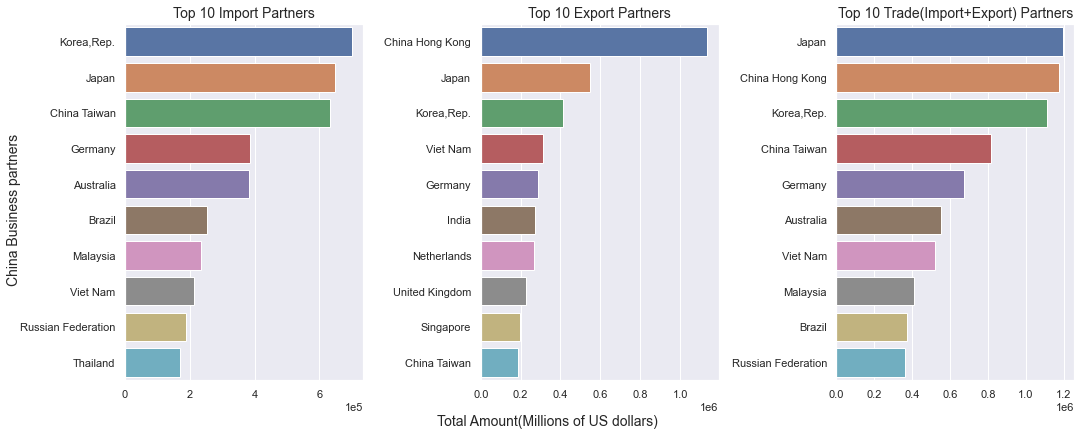

In [41]:
# To find US top trade partners, we aggregate the total trade amount each year
# Find top five import partners (without US)
china_import_year = china_import.filter(['CTYNAME', 'imports'], axis=1)
china_import_year = china_import_year.groupby('CTYNAME').sum()

# drop data that is a region(ex. africa, south america)/US
china_import_year = china_import_year.drop('North America')
china_import_year = china_import_year.drop('China')
china_import_year = china_import_year.drop('Latin America')
china_import_year = china_import_year.drop('Africa')
china_import_year = china_import_year.drop('United States')
china_import_year = china_import_year.drop('Oceania')

china_import_year = china_import_year.sort_values(by=['imports'], ascending=False)

# Find top five export partners (without US)
china_export_year = china_export.filter(['CTYNAME', 'exports'], axis=1)
china_export_year = china_export_year.groupby('CTYNAME').sum()

# drop data that is a region(ex. africa, south america)/US
china_export_year = china_export_year.drop('North America')
china_export_year = china_export_year.drop('China')
china_export_year = china_export_year.drop('Latin America')
china_export_year = china_export_year.drop('United States')
china_export_year = china_export_year.drop('Oceania')
china_export_year = china_export_year.drop('Africa')

china_export_year = china_export_year.sort_values(by=['exports'], ascending=False)

# Find top trade partners (without US)
china_ie_year = pd.concat([china_import_year, china_export_year], axis=1)
china_ie_year['SUM'] = china_ie_year.imports + china_ie_year.exports
china_ie_year = china_ie_year.sort_values(by=['SUM'], ascending=False)


# Visualize to get a clear picture on US top ten trade partners
china_import_year_top = china_import_year[:10]
china_export_year_top = china_export_year[:10]
china_ie_year_top = china_ie_year[:10]
sns.set(rc={'figure.figsize':(15,6)})

fig = plt.figure()
ax1 = plt.subplot(131)
sns.barplot(china_import_year_top.imports,china_import_year_top.index).set_title('Top 10 Import Partners', fontsize=14)
ax2 = plt.subplot(132)
sns.barplot(china_export_year_top.exports,china_export_year_top.index).set_title('Top 10 Export Partners', fontsize=14)
ax3 = plt.subplot(133)
sns.barplot(china_ie_year_top.SUM,china_ie_year_top.index).set_title('Top 10 Trade(Import+Export) Partners', fontsize=14)

ax1.xaxis.label.set_visible(False)
ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax2.xaxis.label.set_visible(False)
ax3.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)
ax3.yaxis.label.set_visible(False)

fig.text(0.5, 0, 'Total Amount(Millions of US dollars)', ha='center', fontsize=14)
fig.text(0, 0.5, 'China Business partners', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.show()

In [42]:
# Create dataframe for each top 5 import partners
def create_china_ie_top10(CTYNAME, df, ie):
    top10 = pd.DataFrame(columns = ['time', ie])
    tmp = df.loc[df['CTYNAME'] == CTYNAME]
    for i, tuples in enumerate(tmp.itertuples(), 0):
        top10.loc[i] = [str(2016+ int(i/12)) +'-'+str(i%12 +1), tuples[2]]
        
    return top10

china_import_top10 = china_import_year_top.index
china_import_df = []
china_export_top10 = china_export_year_top.index
china_export_df = []

for i in range(10):
    china_import_df.append(create_china_ie_top10(china_import_top10[i], china_import, 'imports'))
    china_export_df.append(create_china_ie_top10(china_export_top10[i], china_export, 'exports'))

china_import_df[0].head()
china_export_df[0].head()

,time,exports
0,2016-1,22450.654
1,2016-2,14570.679
2,2016-3,23669.911
3,2016-4,24556.589
4,2016-5,24004.484


In [43]:
# Analysis on import partners
china_imports_model = []
china_imports_its = []

for partners in china_import_df:
    # Convert the datatype to datetime/numeric
    partners.time    = pd.to_datetime(partners.time)
    partners.imports = pd.to_numeric(partners.imports)

    # Remove time >=2020-01
    partners = partners.loc[partners['time'] < '2020-01']

    # Add ITS features (time_feature, intervention, postslope)
    its_import = add_its_features(partners, "time", "2018-03")

    # Declare the model for exports segmented regression analysis
    model_imports = smf.ols(formula='imports ~ time_feature + C(intervention) + postslope', data=its_import)

    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(42)
    res_imports = model_imports.fit()
    china_imports_model.append(res_imports)
    china_imports_its.append(its_import)

# Print the summary output
print(china_imports_model[0].summary())

                            OLS Regression Results                            
Dep. Variable:                imports   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     16.57
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.67e-07
Time:                        16:08:29   Log-Likelihood:                -406.25
No. Observations:                  47   AIC:                             820.5
Df Residuals:                      43   BIC:                             827.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.182e+04 

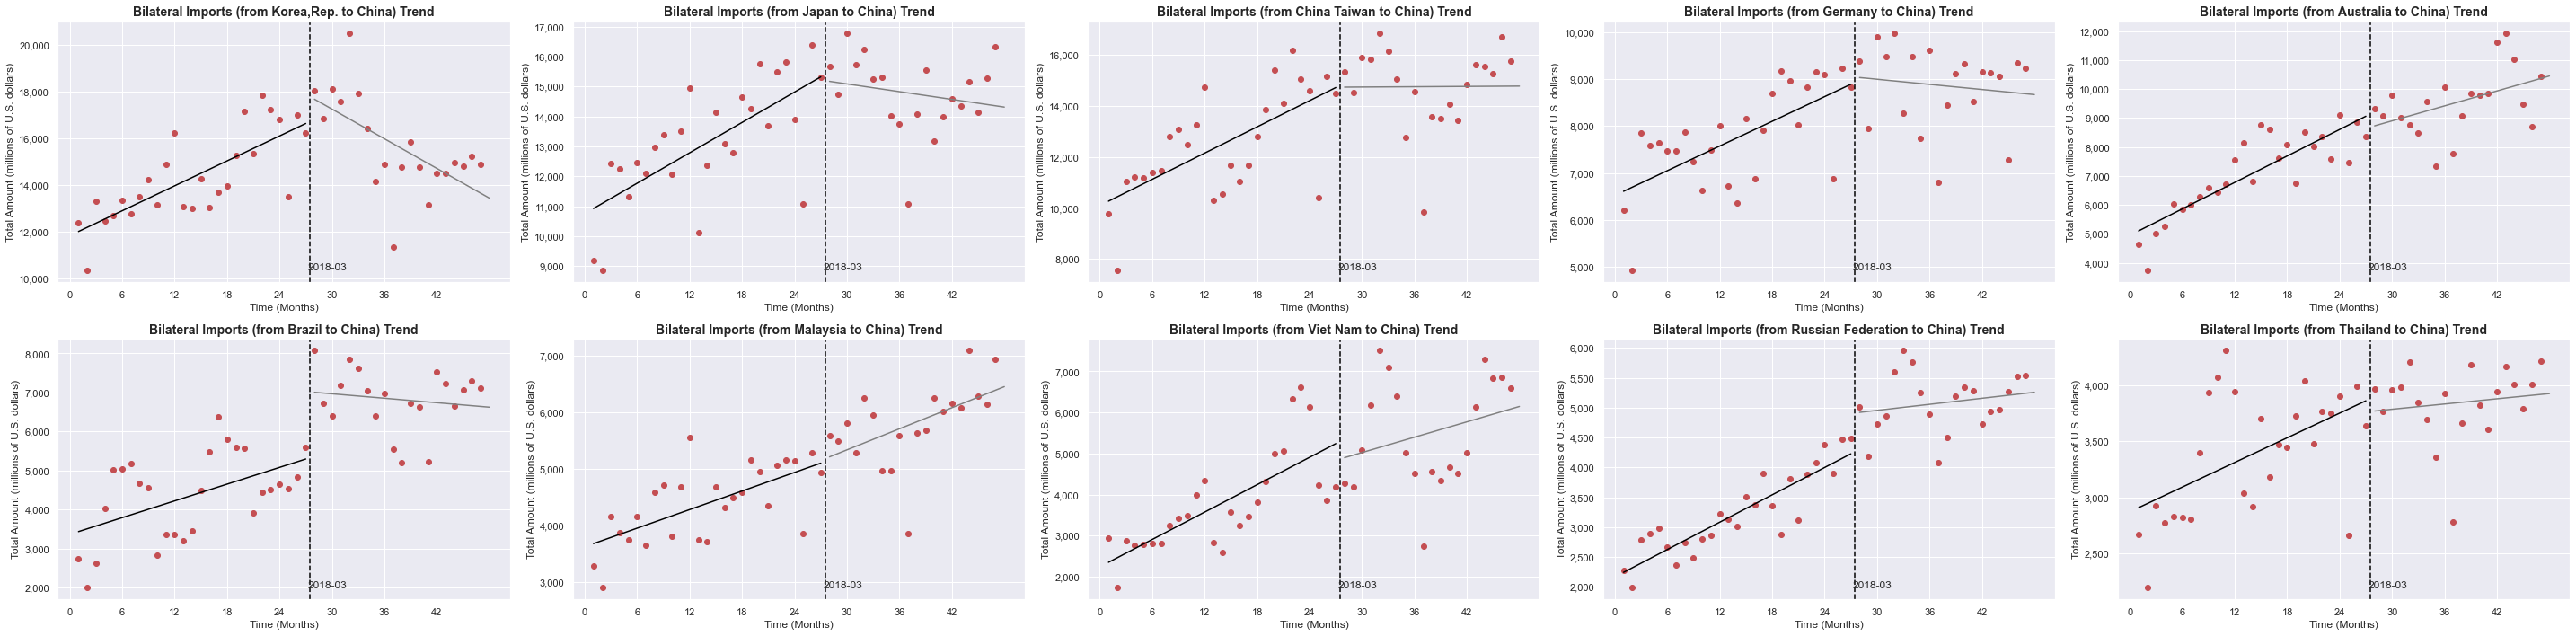

In [44]:
# Plot ITS to see the result on import partners
fig, axs = plt.subplots(2, 5, figsize=(40,10))

for i, ax in enumerate(fig.axes):
    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = china_imports_model[i].params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = china_imports_its[i][china_imports_its[i]["time"] <= "2018-03"]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(us_imports_its[i]), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    ax.scatter(x=china_imports_its[i]["time_feature"], y=china_imports_its[i]["imports"], color='r')
    # Set the axis and format
    ax.set_title("Bilateral Imports (from "+ china_import_top10[i]+ " to China) Trend", loc="center", fontsize=14, weight="bold")
    ax.set_xlabel("Time (Months)")
    ax.set_xticks(list(range(0, len(china_imports_its[i]), 6)))
    ax.set_ylabel("Total Amount (millions of U.S. dollars)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    ax.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    ax.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    ax.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    ax.text(pre_month_num + 2.5, min(china_imports_its[i]["imports"]), "2018-03", ha="center")

plt.tight_layout()
plt.show()

從圖中可看出, 南韓, 巴西, 日本和德國在trade war發生後, 進口至中國的商品總額隨著時間在下降. 其餘地方的進口量並沒有改變太多

In [45]:
# Analysis on export partners
china_exports_model = []
china_exports_its = []

for partners in china_export_df:
    # Convert the datatype to datetime/numeric
    partners.time    = pd.to_datetime(partners.time)
    partners.exports = pd.to_numeric(partners.exports)

    # Remove time >=2020-01
    partners = partners.loc[partners['time'] < '2020-01']

    # Add ITS features (time_feature, intervention, postslope)
    its_export = add_its_features(partners, "time", "2018-03")

    # Declare the model for exports segmented regression analysis
    model_exports = smf.ols(formula='exports ~ time_feature + C(intervention) + postslope', data=its_export)

    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(42)
    res_exports = model_exports.fit()
    china_exports_model.append(res_exports)
    china_exports_its.append(its_export)

# Print the summary output
print(china_exports_model[0].summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.5256
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.667
Time:                        16:08:31   Log-Likelihood:                -455.62
No. Observations:                  47   AIC:                             919.2
Df Residuals:                      43   BIC:                             926.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.276e+04 

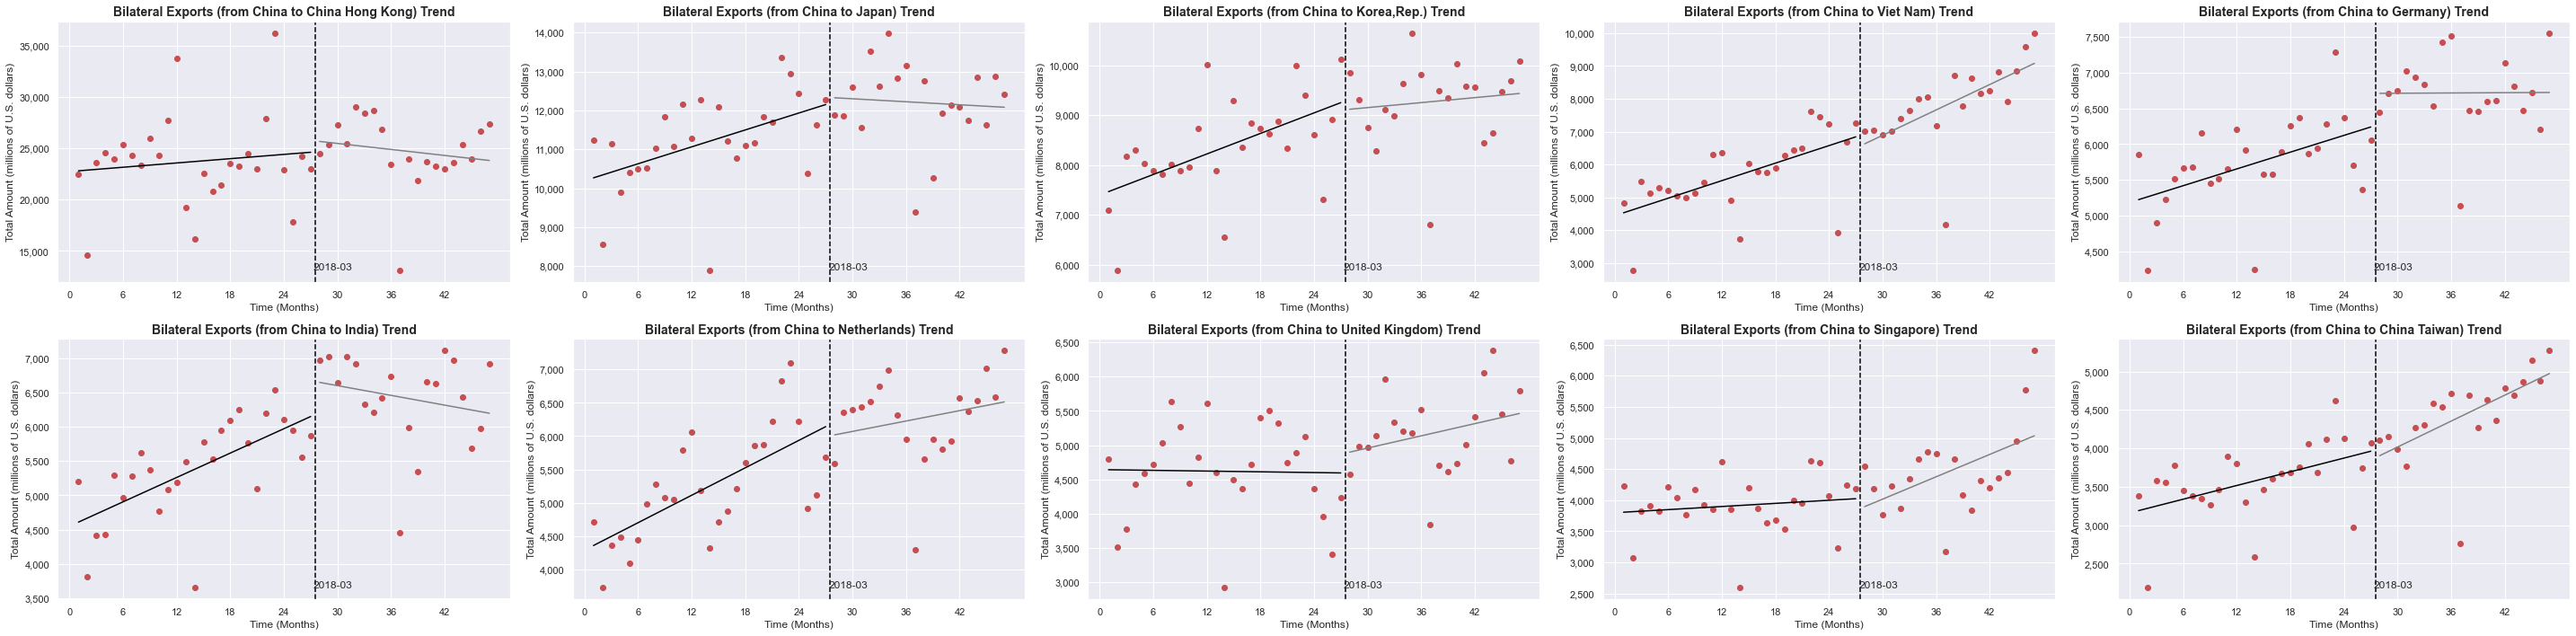

In [46]:
# Plot ITS to see the result on export partners
fig, axs = plt.subplots(2, 5, figsize=(40,10))

for i, ax in enumerate(fig.axes):
    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = china_exports_model[i].params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = china_exports_its[i][china_exports_its[i]["time"] <= "2018-03"]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(china_exports_its[i]), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    ax.scatter(x=china_exports_its[i]["time_feature"], y=china_exports_its[i]["exports"], color='r')
    # Set the axis and format
    ax.set_title("Bilateral Exports (from China to "+ china_export_top10[i]+ ") Trend", loc="center", fontsize=14, weight="bold")
    ax.set_xlabel("Time (Months)")
    ax.set_xticks(list(range(0, len(china_exports_its[i]), 6)))
    ax.set_ylabel("Total Amount (millions of U.S. dollars)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    ax.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    ax.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    ax.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    ax.text(pre_month_num + 2.5, min(china_exports_its[i]["exports"]), "2018-03", ha="center")

plt.tight_layout()
plt.show()

從中國出口至其他地方並沒有受到trade war影響太多, 除了India和Germany在事件發生時出口量有變多, 但隨後也接著下降且總體出口值還是大於trade war發生之前

To look deeper, we calculate the trade war impact and create a table for comparison.

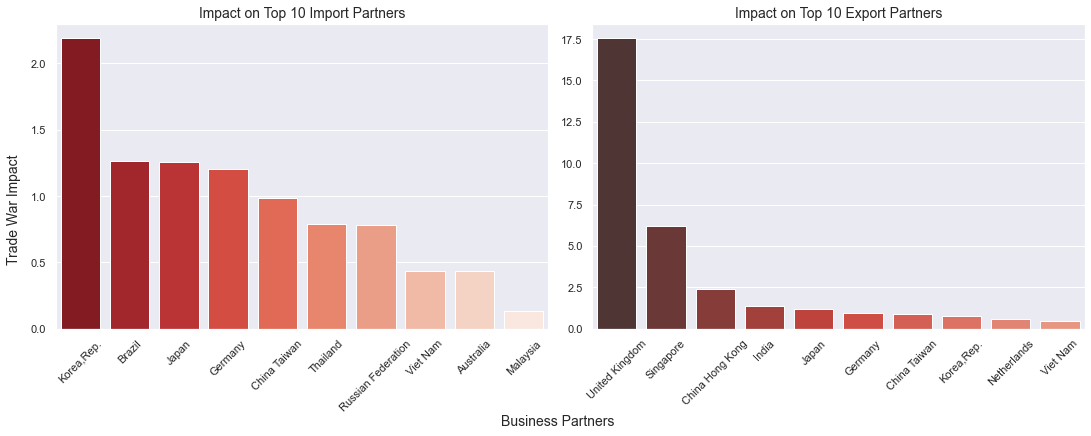

In [47]:
# More analysis on top10 import/export partners
# We use data from ITS reports and propose a new formula: abs(postslope.coeff/time feature.coeff)
import_impact = []
export_impact = []

for i in range(10):
    import_impact.append(np.abs(china_imports_model[i].params[3]/china_imports_model[i].params[2]))
    export_impact.append(np.abs(china_exports_model[i].params[3]/china_exports_model[i].params[2]))

# Visualize
data_import = {'CTYNAME': china_import_top10, 'imports': import_impact}
data_export = {'CTYNAME': china_export_top10, 'exports': export_impact}
china_import_impact = pd.DataFrame(data=data_import)
china_export_impact = pd.DataFrame(data=data_export)

china_import_impact = china_import_impact.sort_values(by=['imports'], ascending=False)
china_export_impact = china_export_impact.sort_values(by=['exports'], ascending=False)

sns.set(rc={'figure.figsize':(15,6)})
fig = plt.figure()
ax1 = plt.subplot(121)
sns.barplot(x=china_import_impact.CTYNAME, y=china_import_impact.imports, data=china_import_impact, capsize=.05, palette="Reds_r").set_title('Impact on Top 10 Import Partners', fontsize=14)
ax2 = plt.subplot(122)
sns.barplot(x=china_export_impact.CTYNAME, y=china_export_impact.exports, data=china_export_impact, capsize=.05, palette="Reds_d").set_title('Impact on Top 10 Export Partners', fontsize=14)

ax1.set_xticklabels(china_import_impact.CTYNAME, rotation=45)
ax2.set_xticklabels(china_export_impact.CTYNAME, rotation=45)

ax1.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

fig.text(0.5, 0, 'Business Partners', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Trade War Impact', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.show()

From the above plot, we can easily view the trade war impact on different business partners. The trade war has more impact on China import partners: South Korea and almost no impact on Malaysia. On the other hand, as being China export partners, UK and Singapore gains more influence from the trade war.

### Conclusion
From the above analysis, trade war between US and China does not have a significant impact on most of their business partners. 

### A whole picture of US & China trade with world partners

To see which place has more trade with US/China, we decide to build a world map, hoping to understand more on US/China trade with other business partners.

In [48]:
# create annual imports+exports dataframe for US and China respectively
us_world_trade = us_ie.drop('CTY_CODE', 1)
us_world_trade = pd.concat([us_world_trade.iloc[:, :2], us_world_trade.iloc[:, 14:15], us_world_trade.iloc[:, 27:28]], axis=1)
us_world_trade['SUM_us'] = us_world_trade.IYR + us_world_trade.EYR
china_index = us_world_trade[(us_world_trade.CTYNAME == 'China')].index
us_world_trade = us_world_trade.drop(china_index)
us_world_trade = us_world_trade.drop('IYR',1)
us_world_trade = us_world_trade.drop('EYR',1)
us_world_trade = us_world_trade.loc[us_world_trade['year'] >= 1996]
us_world_trade = us_world_trade.loc[us_world_trade['year'] <= 2018]

# In order to observe longer time, we use a new China partner dataset from WTO
CHINA_IMPORT_PATH = "data/china_import.csv"
china_longer_import = pd.read_csv(CHINA_IMPORT_PATH, encoding="latin-1")
china_longer_import = china_longer_import.filter(['Partner Economy', 'Year', 'Value'], axis=1)
china_longer_import = china_longer_import.sort_values(by=['Year'])
frame = []
for i in range(23):
    tmp_yr = china_longer_import[china_longer_import['Year'] == 1996+i]
    tmp_yr = tmp_yr.groupby('Partner Economy')['Value'].sum()
    tmp_yr = tmp_yr.to_frame()
    tmp_yr['Year'] = [1996+i for x in range(len(tmp_yr)) ]
    frame.append(tmp_yr)
china_new_import = pd.concat(frame)

CHINA_EXPORT_PATH = "data/china_export.csv"
china_longer_export = pd.read_csv(CHINA_EXPORT_PATH, encoding="latin-1")
china_longer_export = china_longer_export.filter(['Reporting Economy', 'Year', 'Value'], axis=1)
china_longer_export = china_longer_export.sort_values(by=['Year'])
frame = []
for i in range(23):
    tmp_yr = china_longer_export[china_longer_export['Year'] == 1996+i]
    tmp_yr = tmp_yr.groupby('Reporting Economy')['Value'].sum()
    tmp_yr = tmp_yr.to_frame()
    tmp_yr['Year'] = [1996+i for x in range(len(tmp_yr)) ]
    frame.append(tmp_yr)
china_new_export = pd.concat(frame)

china_new_import.rename({ 'Year': 'year', 'Value':'Import'}, axis=1, inplace=True)
china_new_export.rename({ 'Year': 'year', 'Value':'Export'}, axis=1, inplace=True)
china_new_import = china_new_import.reset_index()
china_new_import.rename({'Partner Economy': 'CTYNAME'}, axis=1, inplace=True)
china_new_export = china_new_export.reset_index()
china_new_export.rename({'Reporting Economy': 'CTYNAME'}, axis=1, inplace=True)

china_new_ie = pd.merge(china_new_import, china_new_export, how='left', on=['CTYNAME', 'year'])
china_new_ie['Import'] = china_new_ie['Import'].fillna(0)
china_new_ie['Export'] = china_new_ie['Export'].fillna(0)
china_new_ie['SUM_china'] = china_new_ie.Import + china_new_ie.Export
china_new_ie = china_new_ie.drop('Import',1)
china_world_trade = china_new_ie.drop('Export',1)

# change unit to millions of US dollars
china_world_trade['SUM_china'] = china_world_trade['SUM_china']/1000000
# rearrange column order
china_world_trade = china_world_trade[['year', 'CTYNAME','SUM_china']]

china_world_trade.head()

,year,CTYNAME,SUM_china
0,1996.0,Afghanistan,6.910100
1,1996.0,Albania,4.938522
2,1996.0,Algeria,0.026222
3,1996.0,Angola,487.503074
4,1996.0,Argentina,2426.366048


In [49]:
# conbime US and China trade partner
world_trade = pd.merge(us_world_trade, china_world_trade, how='left', on=['year', 'CTYNAME'])
world_trade['SUM_us'] = world_trade['SUM_us'].fillna(0)
world_trade['SUM_china'] = world_trade['SUM_china'].fillna(0)
world_trade['DIFF'] = world_trade.SUM_us - world_trade.SUM_china
world_trade = world_trade.drop('SUM_us',1)
world_trade = world_trade.drop('SUM_china',1)

# drop US/China itself
china_index = world_trade[(world_trade.CTYNAME == 'China')].index
us_index = world_trade[(world_trade.CTYNAME == 'United States of America')].index
world_trade = world_trade.drop(china_index)
world_trade = world_trade.drop(us_index)

world_trade

,year,CTYNAME,DIFF
0,1996,Greenland,10.6
1,1997,Greenland,12.9
2,1998,Greenland,13.5
3,1999,Greenland,16.5
4,2000,Greenland,16.9
...,...,...,...
5321,1999,International Organizations,0.0
5322,2000,International Organizations,1.0
5323,2001,International Organizations,0.0
5324,2002,International Organizations,0.0


In [51]:
# Construct our world map
# Function to convert to alpah2 country codes and continents
def get_continent(col):
    try:
        cn_a3_code =  country_name_to_country_alpha3(col)
    except:
        cn_a3_code = 'Unknown' 

    return cn_a3_code
country_code = []
for i in world_trade['CTYNAME']:
    country_code.append(get_continent(i))
    
world_trade['code'] = country_code
world_trade = world_trade.loc[world_trade['code'] != 'Unknown']

<ipython-input-51-ff4fdfb3a70b>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



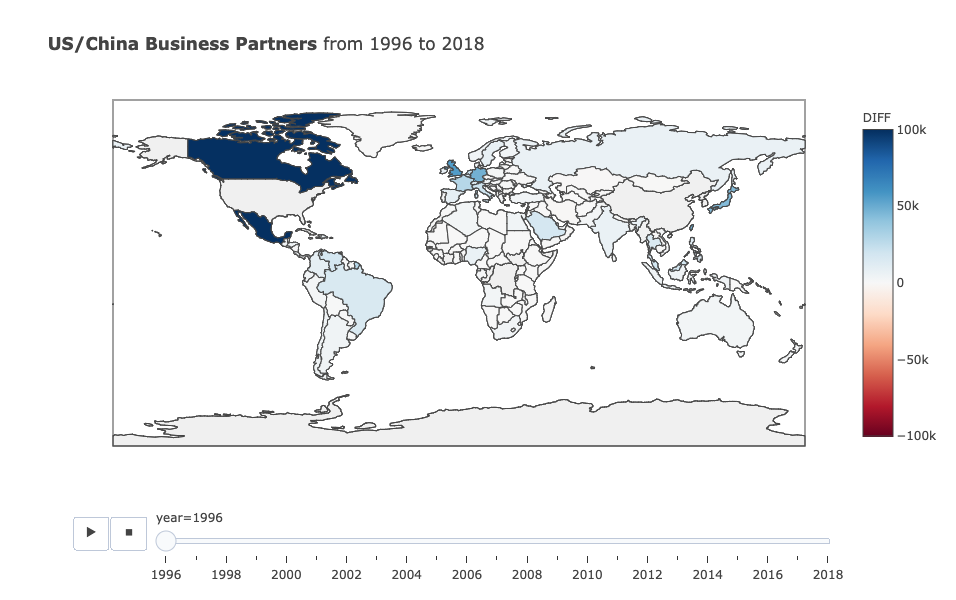

In [65]:
fig = px.choropleth(world_trade, locations="code", color="DIFF", hover_name="CTYNAME", animation_frame="year",
                    color_continuous_scale=px.colors.diverging.RdBu, title='<b>US/China Business Partners</b> from 1996 to 2018',
                     range_color=[-100000,100000],height=600, template=layout)

fig.update_layout(
    title={'x':0.05, 'xanchor': 'left'})
fig.show()

## 5. Which industry/sector has undergone the most severe decline in the trade war?

In [ ]:
# read the dataframe which represents US exports and imports trades with other countries from year 2015 to 2020
df = pd.read_excel("./data/trades_by_goods.xlsx")

# extract exports and imports trades with Chine
df_china = df[df["Country"]=="China"]

# get rid of unnecessary columns and missing data(in this dataframe values are all 0 for the year 2020)
df_china.drop(['Country', 'CTY_CODE'], axis=1, inplace=True)
df_china = df_china[df_china['Year']!=2020]

#df_china

In [ ]:
# rearranging the dataframe to facilitate our analysis work afterwards
df_exports = pd.melt(df_china, id_vars=['Year', 'SITC'], value_vars=['ExportsFASValueBasisJan', 'ExportsFASValueBasisFeb',\
                                                        'ExportsFASValueBasisMar', 'ExportsFASValueBasisApr',\
                                                        'ExportsFASValueBasisMay', 'ExportsFASValueBasisJun',\
                                                        'ExportsFASValueBasisJul', 'ExportsFASValueBasisAug',\
                                                        'ExportsFASValueBasisSep', 'ExportsFASValueBasisOct',\
                                                        'ExportsFASValueBasisNov', 'ExportsFASValueBasisDec'])
df_imports = pd.melt(df_china, id_vars=['Year', 'SITC'], value_vars=['GenImportsCustomsValBasisJan', 'GenImportsCustomsValBasisFeb',\
                                                        'GenImportsCustomsValBasisMar', 'GenImportsCustomsValBasisApr',\
                                                        'GenImportsCustomsValBasisMay', 'GenImportsCustomsValBasisJun',\
                                                        'GenImportsCustomsValBasisJul', 'GenImportsCustomsValBasisAug',\
                                                        'GenImportsCustomsValBasisSep', 'GenImportsCustomsValBasisOct',\
                                                        'GenImportsCustomsValBasisNov', 'GenImportsCustomsValBasisDec'])

# create a column representing the time
month_mapping = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10,\
                 'Nov':11,'Dec':12}
df_exports['variable'] = df_exports['variable'].apply(lambda x: month_mapping[x[-3:]])
df_imports['variable'] = df_imports['variable'].apply(lambda x: month_mapping[x[-3:]])

time_exports = pd.DataFrame({'year': list(df_exports['Year']),
                   'month': list(df_exports['variable']),
                   'day': [1 for i in range(len(df_exports))]})
time_imports = pd.DataFrame({'year': list(df_imports['Year']),
                   'month': list(df_imports['variable']),
                   'day': [1 for i in range(len(df_imports))]})
df_exports['time'] = pd.to_datetime(time_exports)
df_imports['time'] = pd.to_datetime(time_imports)

# take a look at what df_exports and df_imports look like
df_exports.head(5)

In [ ]:
# A brief ITS analysis on exports for each sector
sectors = list(df_china['sitc_sdesc'])
for i in range(10):
    df = df_exports[df_exports['SITC']==i].sort_values(by='time')
    df = add_its_features(df, "time", "2018-03")
    model = smf.ols(formula='value ~ time_feature + C(intervention) + postslope', data=df)
    res = model.fit()
    plot_its_result(df, res, "time", "value", "2018-03", sectors[i])

In [ ]:
# A brief ITS analysis on imports for each sector
for i in range(10):
    df = df_imports[df_imports['SITC']==i].sort_values(by='time')
    df = add_its_features(df, "time", "2018-03")
    model = smf.ols(formula='value ~ time_feature + C(intervention) + postslope', data=df)
    res = model.fit()
    plot_its_result(df, res, "time", "value", "2018-03", sectors[i])

## References

[1] 